In [1]:

#load needed packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) #set the tick and labelsizes for the figure drawing

In [23]:
#data loading

supercluster_mrna = pd.read_csv( "Supercluster_iPSC_network_mRNA_all_zelllines.csv").reset_index().set_index("external_gene_name")
supercluster_mirna = pd.read_csv("miR_superclustering.csv")

#miRNA target data 
#miRNA base expression data
mirna_edges = pd.read_csv("mirna_edges2")
baseline_expression = pd.read_csv("mirna_base_expression.csv")

#load differential expression data to compare differential expressed genes in all three cell lines
ad2 = pd.read_csv("iPSC_differentiation_mRNA_only_AD2-results-with-normalized_significant.csv")
ad3 = pd.read_csv("iPSC_differentiation_mRNA_only_AD3-results-with-normalized_significant.csv")
eight = pd.read_csv("iPSC_differentiation_mRNA_only_840-results-with-normalized_significant.csv")

#load a self curated ion channel list which is also available at the github repository
ion_channel = pd.read_csv("Ion_channels.csv")
s

In [6]:
#reduce mirna and mrna data 
supercluster_mirna = supercluster_mirna.set_index("Row.names")
supercluster_mirna_end = supercluster_mirna.iloc[:,1:-1]
supercluster_mrna_end = supercluster_mrna.iloc[:,2:-1]
supercluster_mirna_end.index
gesamt = pd.concat([supercluster_mirna_end, supercluster_mrna_end])

                                    gene_biotype_x
protein_coding                               12781
lncRNA                                        2042
processed_pseudogene                           740
transcribed_unprocessed_pseudogene             145
TEC                                            129
transcribed_processed_pseudogene                76
unprocessed_pseudogene                          55
transcribed_unitary_pseudogene                  34
snoRNA                                           7
miRNA                                            6


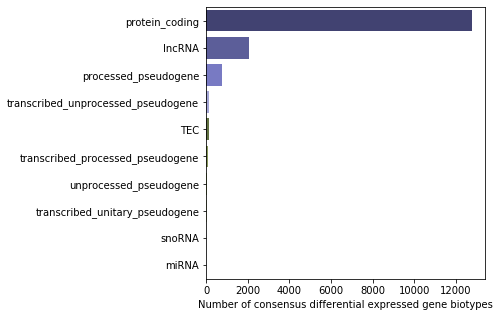

In [3]:
plt.rcParams['svg.fonttype'] = 'none'


def get_biotype_differential_exp(df1, df2, df3):
    
    """ sort based on biotype expression patterns and get counts"""

    ad2 = df1.set_index("ensembl_gene_id_version")
    ad3 = df2.set_index("ensembl_gene_id_version")[["gene_biotype", "baseMean"]]
    eight = df3.set_index("ensembl_gene_id_version")[["gene_biotype", "baseMean"]]
    
    ad2_biotype = pd.merge(ad3,
                           ad2,
                           how="inner",
                           left_index=True,
                           right_index=True)
    all_biotype = pd.merge(ad2_biotype,
                           eight,
                           how="inner",
                           left_index=True,
                           right_index=True)
    biotype_counts = pd.DataFrame(all_biotype["gene_biotype_x"].value_counts().sort_values(
            ascending=False).iloc[:10])
   
    # get the number of counts for each biotype
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.barplot(data=biotype_counts.T, orient="h", palette="tab20b")
    plt.xlabel("Number of consensus differential expressed gene biotypes")
    #plt.savefig("Consensus-biotype-expression.svg", quality = 90, dpi = 600, transparent = True, bbox_inches = "tight")


get_biotype_differential_exp(ad2, ad3, eight)

In [ ]:
# here we draw the potential plots of gene after z-score normalization
#select marker of interest to draw
nociceptor_marker = [ "CALCB", "CALCA", "TRPV1", "SCN1A", "SCN2A", "SCN9A", "CLCN3"]
pluripotency_marker = ["SOX2", "POU5F1", "NANOG", "ZFP42", "TNFRSF8"]
neural_crest_marker = [ "NEUROG1", "NEUROG2", "SOX10", "EBF1", "TFAP2", "NTRK1", "RUNX1"]


def draw_curves(df, genes_liste, title):
    
    """trajectory input, marker input, and the title of the marker
    draws the plot"""
    df_curv = df.reset_index().set_index("external_gene_name").iloc[:, 3:-1]
    print(df_curv)
    df_curv.columns = [
        1, 1, 1, 5, 5, 5, 9, 9, 9, 16, 16, 16, 26, 26, 26, 36, 36, 36
    ]
    df_curves = df_curv[df_curv.index.isin(genes_liste)]
    sns.despine()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(data=df_curves.T,
                    hue=df_curves.index,
                    palette="tab20",
                    legend=False)
    sns.lineplot(data=df_curves.T, alpha=0.5, palette="tab20"),
    plt.title(title)
    plt.savefig(title + "_gene_expression_marker.svg",
                quality=90,
                dpi=600,
                transparent=True,
                bbox_inches="tight")


draw_curves(supercluster_mrna, pluripotency_marker, "Pluripotency Marker")
draw_curves(supercluster_mrna, nociceptor_marker, "Nociceptive Marker")
draw_curves(supercluster_mrna, neural_crest_marker, "Neural Crest Marker")

In [ ]:
# miRNA expression data is used for plotting marker miRNAs 
#plot the miRNA data for queried selected miRNAs

pluripotency_mirna = [ "hsa-miR-302a-3p", "hsa-miR-200a-3p", "hsa-miR-302b-3p", "hsa-miR-302c-5p"]
neural_crest_mirna = [ "hsa-miR-25-3p", "hsa-miR-493-5p", "hsa-miR-18b-5p", "hsa-miR-129-2-3p"]
nociceptor_mirna = ["hsa-let-7d-5p", "hsa-let-7g-3p", "hsa-miR-450a-1-3p"]


def draw_curves_mirna(df, mirna_liste, title):
    """same as for genes, draw miRNA marker"""
    df_curv = df.reset_index().set_index("Row.names").iloc[:, 1:-1]

    df_curv.columns = [1, 1, 1, 5, 5, 5, 9, 9, 9, 16, 16, 16, 26, 26, 26, 36, 36, 36 ] # set column

    df_curves = df_curv[df_curv.index.isin(mirna_liste)]# check if the miRNA is in the list

    sns.despine() # get rid of axis spines
    
    #drawing
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(data=df_curves.T,
                    hue=df_curves.index,
                    palette="tab20b",
                    legend=False)
    sns.lineplot(data=df_curves.T, alpha=0.5, palette="tab20b"),
    plt.title(title)
    plt.savefig(title + "_mirna_expression_marker.svg",
                quality=90,
                dpi=600,
                transparent=True,
                bbox_inches="tight")


draw_curves_mirna(supercluster_mirna, pluripotency_mirna, "Pluripotency")
draw_curves_mirna(supercluster_mirna, neural_crest_mirna, "Neural Crest")
draw_curves_mirna(supercluster_mirna, nociceptor_mirna, "Nociceptor")

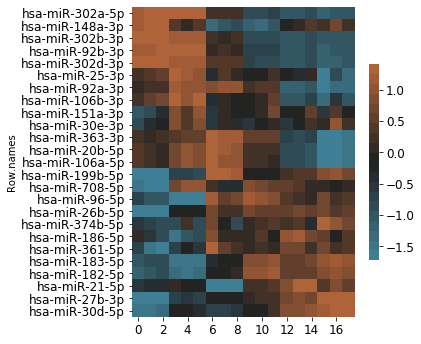

In [24]:
# get top enriched miRNAs per cluster

gesamt_expression = pd.merge(supercluster_mirna,
                             baseline_expression,
                             how="left",
                             left_on="Row.names",
                             right_on="Row.names")


def top10_mirnas_cluster(df, cluster):
    """ get the top 5 mirnas per cluster"""
    expression = pd.DataFrame()

    for i in [3, 4, 5, 2, 1]:
        df_express = df[df[cluster] == i].sort_values(["baseMean"],
                                    ascending=False).set_index("Row.names").iloc[:5, 1:-2]
        expression = pd.concat([expression, df_express])

    return expression


top_expressed = top10_mirnas_cluster(gesamt_expression, "hierachical_cluster")

In [ ]:
# draw the heatmaps
fig, ax = plt.subplots(figsize=(5, 18))
sns.heatmap(top_expressed,
            square=True,
            robust=True,
            cbar_kws={"shrink": 0.2},
            cmap=sns.diverging_palette(222, 30, l=50, n=20, center="dark"))
plt.savefig("top5_expressed_miRNAs_cluster.svg",
            quality=90,
            transparent=True,
            dpi=600,
            bbox_inches="tight")